In [1]:
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gmean
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from doe_modules.preferences import kwarg_savefig, outputdir, f2s
from doe_modules.ml import plot_pr, plot_roc
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score
from sklearn.linear_model import LogisticRegression

from doe_modules.simulation.esm4_metrics import *

In [2]:
top10 = np.array([
    "positive_pathway_coverage", 
    "max_positive_edge_density", 
    "max_positive_cascade_length_ratio", 
    "edge_effectivity",
    "mean_factor_density",
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "pathway_coverage",
    "max_cascade_length_ratio",
    "effective_edge_positivity"
])

negs = [
    "max_positive_edge_density", 
    "max_positive_cascade_length_ratio", 
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "effective_edge_positivity"
]

key_features = [
    "positive_pathway_coverage", 
    "max_positive_edge_density", 
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "pathway_coverage",
    "effective_edge_positivity"
]

In [3]:
from tqdm.notebook import tqdm

edges = np.array(list(map(list, product([-1, 0, 1], repeat=10))))

n = (lambda arr: (-1 + np.sqrt(1 + 8 * arr.size)) / 2)(edges[0])
ppc = np.fromiter(map(positive_pathway_coverage, edges), float).reshape(-1, 1)
maxped = np.fromiter(map(lambda arr: 1 - max_positive_edge_density(arr), edges), float).reshape(-1, 1)
maxsed = np.fromiter(map(lambda arr: 1 - max_synergetic_edge_density(arr), edges), float).reshape(-1, 1)
meanped = np.fromiter(map(lambda arr: 1 - mean_positive_edge_density(arr), edges), float).reshape(-1, 1)
pc = np.fromiter(map(pathway_coverage, edges), float).reshape(-1, 1)
eep = np.fromiter(map(lambda arr: 1 - effective_edge_positivity(arr), edges), float).reshape(-1, 1)

full = np.hstack([ppc, maxped, maxsed, meanped, pc, eep])

arr_top10 = np.hstack([
    np.fromiter(
        map(
            (lambda arr: 1 - eval(f)(arr)) if f in negs else eval(f), 
            edges
        ), float
    ).reshape(-1, 1) for f in top10
])


df = pd.concat(
    [
        pd.read_feather(f"{outputdir}/esm_test4.feather"),
        pd.DataFrame(
            arr_top10,
            columns=top10
        ),
        pd.DataFrame({
            f"arithmetic{i + 1}": mat.mean(axis=1) for i, mat in tqdm(enumerate(
                [
                    full[:, np.where(arr_bool)[0]] for arr_bool in map(
                        lambda lst_bool: np.array(lst_bool), 
                        product(*[[True, False]] * 6)
                    ) if arr_bool.sum() > 1
                ]
            ))
        })
    ],
    axis=1
)

df = df.assign(
    better_with_pb=df.pb > df.cloo
)

0it [00:00, ?it/s]

In [4]:
df

,cloo,pb,v,,positive_pathway_coverage,max_positive_edge_density,max_positive_cascade_length_ratio,edge_effectivity,mean_factor_density,max_synergetic_edge_density,...,arithmetic49,arithmetic50,arithmetic51,arithmetic52,arithmetic53,arithmetic54,arithmetic55,arithmetic56,arithmetic57,better_with_pb
0,0.000000,0.000000,0,neither,0.0,1.00,1.00,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,False
1,0.000000,0.000000,0,neither,0.0,1.00,1.00,1.0,0.9,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,False
2,0.000000,0.000000,0,neither,0.0,1.00,1.00,1.0,1.0,0.833333,...,0.888889,0.916667,0.888889,0.916667,0.833333,0.944444,1.00,0.916667,0.916667,False
3,0.000000,0.000000,0,neither,0.0,1.00,1.00,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,False
4,0.000000,0.000000,0,neither,0.0,1.00,1.00,1.0,0.8,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59044,0.750000,0.750000,3,both,1.0,0.25,0.25,1.0,0.8,0.250000,...,0.250000,0.375000,0.416667,0.625000,0.125000,0.500000,0.75,0.250000,0.500000,False
59045,1.000000,0.750000,1,C+LOO,1.0,0.00,0.00,1.0,1.0,0.000000,...,0.033333,0.050000,0.333333,0.500000,0.000000,0.366667,0.55,0.050000,0.500000,False
59046,0.333333,-0.333333,0,neither,1.0,0.50,0.25,1.0,1.0,0.500000,...,0.322222,0.400000,0.555556,0.750000,0.333333,0.488889,0.65,0.233333,0.583333,False
59047,0.750000,0.750000,3,both,1.0,0.40,0.25,1.0,0.9,0.400000,...,0.233333,0.350000,0.466667,0.700000,0.200000,0.433333,0.65,0.150000,0.500000,False


def cai_performance(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return np.vectorize(lambda t: metric(data.cloo < data.pb, data.cai <= t))(xrange)

def cai_performance_plot(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return (xrange, cai_performance(data, metric, xrange))

def argmax_cai(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    y = cai_performance(data, metric, xrange)
    argmax = np.argmax(y)
    return (xrange[argmax], y[argmax])

In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score, recall_score, precision_score, precision_recall_curve

fig, ax = plt.subplots()

nx = np.linspace(1, 10, 10)

ax.plot(nx, np.vectorize(lambda x: x / (1 + x))(nx), label="x/(1+x)", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 / (1 + np.e ** (-x)))(nx), label="1/(1+e^-x)", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 - np.e ** (-x))(nx), label="1 - e^-x", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 - (1 / x))(nx), label="div2", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 - (1 /  (x ** 2)))(nx), label="a", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 - (1 /  (x ** .5)))(nx), label="div3", marker="o")

ax.legend()

In [6]:
def div22():
    weight = np.array([1 / n, 1 - (1 / n)])
    val = np.hstack([
        ppc, 
        maxped
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div3():
    weight = np.array([1, n, (n + 1) * (n - 1), 1])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div1234():
    weight = np.array([1, n, n ** 2, 1])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div123():
    weight = np.array([1, n, n ** 2])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div234():
    weight = np.array([n, n ** 2, 1])
    val = np.hstack([
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div23():
    weight = np.array([n, n ** 2])
    val = np.hstack([
        maxped,
        meanped,
    ])
    return (weight * val).sum(axis=1) / weight.sum()

In [7]:
# df = pd.concat(
#     [
#         df, 
#         pd.DataFrame(dict(
#             div22=div22(),
#             div3=div3(),
#             div1234=div1234(),
#             div123=div123(),
#             div234=div234(),
#             div23=div23()
#         ))
#     ],
#     axis=1
# )

In [8]:
feat_names_short = dict(
    pathway_coverage=r"P%",
    pathway_positivity=r"P$_{(+)}$/P",
    pathway_negativity=r"P$_{(-)}$/P",
    positive_pathway_coverage=r"P$_{(+)}$%",
    negative_pathway_coverage=r"P$_{(-)}$%",
    sparse_pathway_coverage=r"P$_{(0)}$%",
    edge_coverage=r"R%",
    edge_positivity=r"R$_{(+)}$/R",
    edge_negativity=r"R$_{(-)}$/R",
    positive_edge_coverage=r"R$_{(+)}$%",
    negative_edge_coverage=r"R$_{(-)}$%",
    sparse_edge_coverage=r"R$_{(0)}$%",
    edge_effectivity=r"R$^*$/R",
    effective_edge_positivity=r"R$^*_{(+)}$/R$^*$",
    effective_edge_negativity=r"R$^*_{(-)}$/R$^*$",
    max_edge_density=r"MaxRW/R$^*$",
    mean_edge_density=r"RW%",
    max_positive_edge_density=r"MaxRW$_{(+)}$/R$^*$",
    mean_positive_edge_density=r"RW$_{(+)}$%",
    max_synergetic_edge_density=r"MaxRW$_&$/R$^*$",
    mean_synergetic_edge_density=r"RW$_&$%",
    max_factor_density=r"MaxFW/n",
    mean_factor_density=r"FW%",
    max_positive_factor_density=r"MaxFW$_{(+)}$/n",
    mean_positive_factor_density=r"FW$_{(+)}$%",
    max_synergetic_factor_density=r"MaxFW$_&$/n",
    mean_synergetic_factor_density=r"FW$_&$%",
    max_cascade_length_ratio=r"MaxCL/n",
    mean_cascade_length_ratio=r"CL%",
    max_positive_cascade_length_ratio=r"MaxCL$_{(+)}$/n",
    mean_positive_cascade_length_ratio=r"CL$_{(+)}$%",
    max_synergetic_cascade_length_ratio=r"MaxCL$_&$/n",
    mean_synergetic_cascade_length_ratio=r"CL$_&$%",
    # cascade_coverage=r"C%",
    # positive_cascade_coverage=r"C$_+$%",
    # synergetic_cascade_coverage=r"C$_&$%",
)

In [9]:
from sklearn.model_selection import StratifiedKFold, train_test_split

from scipy.interpolate import interp1d
from scipy.stats import bootstrap

from doe_modules.preferences import kwarg_bootstrap

In [10]:
def roc_integration(
    data, key
):
    data_key = data.loc[data.feat_names == key, ["x", "y", "folds"]]
    return pd.DataFrame({
        "feat_names": [key] * data_key.x.unique().size,
        "x": np.sort(data_key.x.unique()), 
        **{
            f"fold_{i}": interp1d(
                np.sort(data_key.x[data_key.folds == i].values),
                data_key.y[data_key.folds == i].values[
                np.argsort(data_key.x[data_key.folds == i].values)
                ]
            )(np.sort(data_key.x.unique())) for i in data_key.folds.unique()
        },
    })


def roc_multimetric_integration(data):
    return pd.concat(
        [roc_integration(data, key) for key in data.feat_names.unique()],
        axis=0
    )

In [409]:
xs, ys = np.array([]), np.array([])
feat_names = []
folds = []

metrics = top10
aurocs = {key: [] for key in metrics}

for i, (_, te) in enumerate(
    StratifiedKFold(
        n_splits=10, shuffle=True, random_state=0
    ).split(df[metrics], df.better_with_pb)
):
    x_te, y_te = df[metrics].loc[te, :], df.better_with_pb[te]

    for key in metrics:
        x, y = roc_curve(y_te, x_te[key])[:2]
        xs, ys = np.hstack([xs, x]), np.hstack([ys, y])
        feat_names += [key] * x.size
        folds += [i] * x.size
        aurocs[key] += [roc_auc_score(y_te, x_te[key])]


df_roc = pd.DataFrame({
    "x": xs, "y": ys, "feat_names": feat_names, "folds": folds
})

aurocs_ci = {
    k: bootstrap(
        (v,), **kwarg_bootstrap
    ).confidence_interval for k, v in aurocs.items()
}

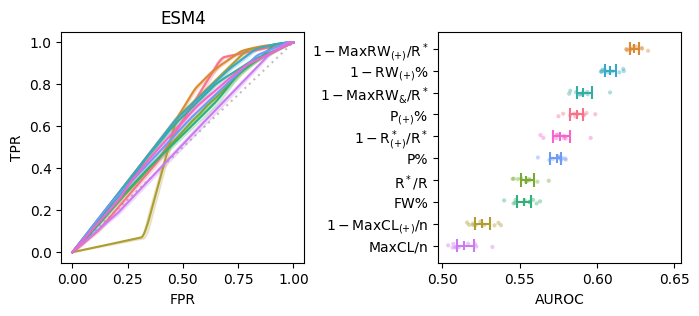

In [410]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=.55)

df_roc_integrated = roc_multimetric_integration(df_roc)
cmap = sns.color_palette("husl", len(metrics))

for i, key in enumerate(metrics):
    df_roc_sep = df_roc_integrated.loc[
        df_roc_integrated.feat_names == key, :
    ]
    ax[0].plot(
        df_roc_sep.x,
        df_roc_sep.iloc[:, 2:].mean(axis=1),
        c=cmap[i]
    )
    ax[0].fill_between(
        df_roc_sep.x, 
        df_roc_sep.iloc[:, 2:].mean(axis=1) - df_roc_sep.iloc[:, 2:].std(axis=1),
        df_roc_sep.iloc[:, 2:].mean(axis=1) + df_roc_sep.iloc[:, 2:].std(axis=1),
        color=cmap[i], alpha=.2, zorder=-(i + 1) * 10
    )

ax[0].plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
ax[0].set(title="ESM4", xlabel="FPR", ylabel="TPR")
# ax.legend(fontsize="x-small", loc="lower right")

sorted_feat_names = pd.DataFrame(aurocs).mean().sort_values(ascending=False).index
sorted_cmap = pd.Series(
    [i for i in range(len(metrics))], index=metrics
)[sorted_feat_names].apply(lambda i: cmap[i]).tolist()
sorted_auroc = pd.DataFrame({
    "AUROC": np.array([aurocs[k] for k in sorted_feat_names]).ravel(),
    "feat_names": np.array([[k] * len(aurocs[k]) for k in sorted_feat_names]).ravel(),
    "": np.array([
        ["$1-$" + feat_names_short[k] if k in negs else feat_names_short[k]] * len(aurocs[k]) for k in sorted_feat_names
    ]).ravel()
})

fixed_cmap = {k: v for k, v in zip(sorted_feat_names, sorted_cmap)}

sns.stripplot(
    data=sorted_auroc, 
    x="AUROC", y="", size=3, hue="", 
    ax=ax[1], 
    palette=sorted_cmap, alpha=.4
)
ax[1].set(xlim=np.array(ax[1].get_xlim()) + np.array([0, .015]))


sorted_mean_auroc = sorted_auroc.loc[
    :, ["feat_names", "AUROC"]
].groupby("feat_names").mean().loc[sorted_feat_names]

ylim = (lambda v1, v2: v2 - v1)(*np.sort(np.array(ax[1].get_ylim())))
        
for i, name in enumerate(sorted_feat_names):
    ax[1].vlines(sorted_mean_auroc.loc[name], i - (ylim * .02), i + (ylim * .02), color=sorted_cmap[i])
    ax[1].vlines(aurocs_ci[name].low, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax[1].vlines(aurocs_ci[name].high, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax[1].hlines(i, aurocs_ci[name].low, aurocs_ci[name].high, color=sorted_cmap[i])
    # center = np.array(ax[1].get_xlim()).mean()
    # is_larger = (sorted_mean_auroc.loc[name] > center).item()
    # low, high = aurocs_ci[name].low, aurocs_ci[name].high
    # ax[1].text(
    #     low - 0.015 if is_larger else high + 0.015,
    #     i, f"{f2s(sorted_mean_auroc.loc[name].item())} [{f2s(low)}–{f2s(high)}]",
    #     ha="right" if is_larger else "left", va="center", size=7
    # )

# fig.savefig(f"{outputdir}/test4_roc", **kwarg_savefig)

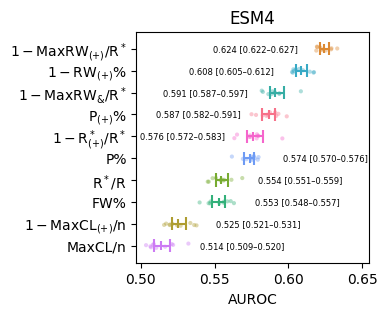

In [415]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.stripplot(
    data=sorted_auroc, 
    x="AUROC", y="", size=3, hue="", 
    ax=ax, 
    palette=sorted_cmap, alpha=.4
)
ax.set(xlim=np.array(ax.get_xlim()) + np.array([0, .015]), title="ESM4")


sorted_mean_auroc = sorted_auroc.loc[
    :, ["feat_names", "AUROC"]
].groupby("feat_names").mean().loc[sorted_feat_names]

ylim = (lambda v1, v2: v2 - v1)(*np.sort(np.array(ax.get_ylim())))
        
for i, name in enumerate(sorted_feat_names):
    ax.vlines(sorted_mean_auroc.loc[name], i - (ylim * .02), i + (ylim * .02), color=sorted_cmap[i])
    ax.vlines(aurocs_ci[name].low, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax.vlines(aurocs_ci[name].high, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax.hlines(i, aurocs_ci[name].low, aurocs_ci[name].high, color=sorted_cmap[i])
    center = np.array(ax.get_xlim()).mean()
    is_larger = (sorted_mean_auroc.loc[name] > center).item()
    low, high = aurocs_ci[name].low, aurocs_ci[name].high
    ax.text(
        low - 0.015 if is_larger else high + 0.02,
        i, f"{f2s(sorted_mean_auroc.loc[name].item())} [{f2s(low)}–{f2s(high)}]",
        ha="right" if is_larger else "left", va="center", size=6
    )

fig.savefig(f"{outputdir}/test4_roc", **kwarg_savefig)

[Text(0.5, 1.0, 'ESM4'), Text(0.5, 0, 'FPR'), Text(0, 0.5, 'TPR')]

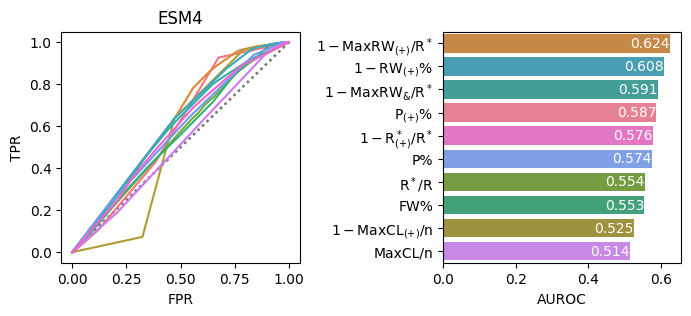

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=.6)

features = [df.loc[:, v] for v in top10]

names = [
    r"$1-$" + feat_names_short[v] if v in negs else feat_names_short[v] for v in top10
]


cmap = sns.color_palette("husl", len(features))

df_bar = pd.DataFrame({
    "": names,
    "AUROC": [roc_auc_score(df.better_with_pb, y) for y in features],
    "cmap": cmap
}, index=top10).sort_values("AUROC", ascending=False)

sns.barplot(
    data=df_bar, x="AUROC", y="",
    hue="", legend=False, ax=ax[1],
    palette=df_bar.cmap.values.tolist()
)

for i, y in enumerate(features):
    ax[0].plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i],
        # + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax[0].plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
    
    auroc = roc_auc_score(df.better_with_pb, y)
    
    ax[1].text(
        auroc, 
        np.where(df_bar.loc[:, ""] == names[i])[0].item(), 
        f2s(auroc), ha="right", va="center", color="w"
    )

# ax[0].legend(fontsize="x-small", loc="upper center", bbox_to_anchor=(.5, -.2), ncol=2)
ax[0].set(title="ESM4", xlabel="FPR", ylabel="TPR")

# fig.savefig(f"{outputdir}/test4_roc", **kwarg_savefig)

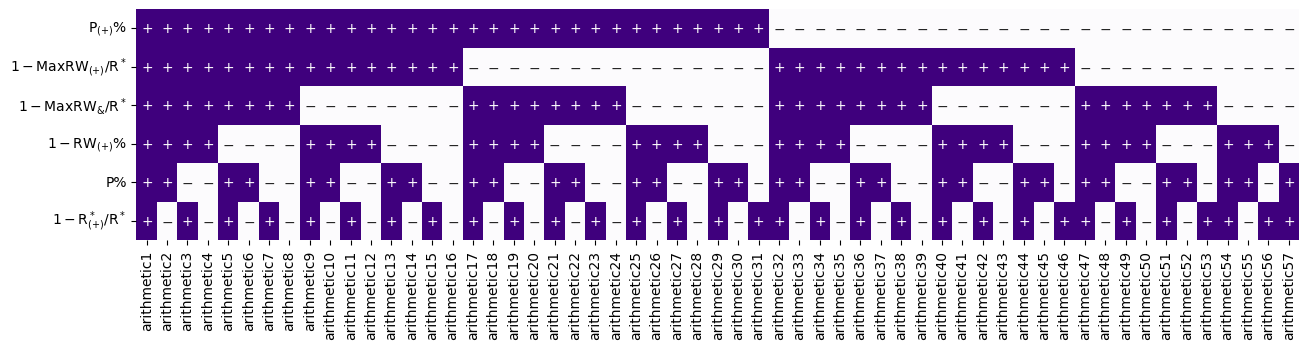

In [74]:
fig, ax = plt.subplots(figsize=(15, 3))

arr_condition = np.vstack([
    arr_bool for arr_bool in map(
        lambda lst_bool: np.array(lst_bool), 
        product(*[[True, False]] * 6)
    ) if arr_bool.sum() > 1
])

df_arr_condition = pd.DataFrame(
    arr_condition,
    index=[f"arithmetic{i + 1}" for i in range(57)],
    columns=[
        r"$1-$" + feat_names_short[v] if v in negs else feat_names_short[v] for v in key_features
    ]
).T

sns.heatmap(
    data=df_arr_condition,
    cbar=False, 
    fmt="s",
    annot=df_arr_condition.applymap(
        lambda x: "$+$" if x else "$-$"
    ),
    cmap="Purples"
)

fig.savefig(f"{outputdir}/test4_arithmetic_conditions", **kwarg_savefig)

In [416]:
xs, ys = np.array([]), np.array([])
feat_names = []
folds = []

metrics = [
    f"arithmetic{i + 1}" for i in range(len(arr_condition))
]
aurocs = {key: [] for key in metrics}

for i, (_, te) in enumerate(
    StratifiedKFold(
        n_splits=10, shuffle=True, random_state=0
    ).split(df[metrics], df.better_with_pb)
):
    x_te, y_te = df[metrics].loc[te, :], df.better_with_pb[te]

    for key in metrics:
        x, y = roc_curve(y_te, x_te[key])[:2]
        xs, ys = np.hstack([xs, x]), np.hstack([ys, y])
        feat_names += [key] * x.size
        folds += [i] * x.size
        aurocs[key] += [roc_auc_score(y_te, x_te[key])]


df_roc = pd.DataFrame({
    "x": xs, "y": ys, "feat_names": feat_names, "folds": folds
})

aurocs_ci = {
    k: bootstrap(
        (v,), **kwarg_bootstrap
    ).confidence_interval for k, v in aurocs.items()
}

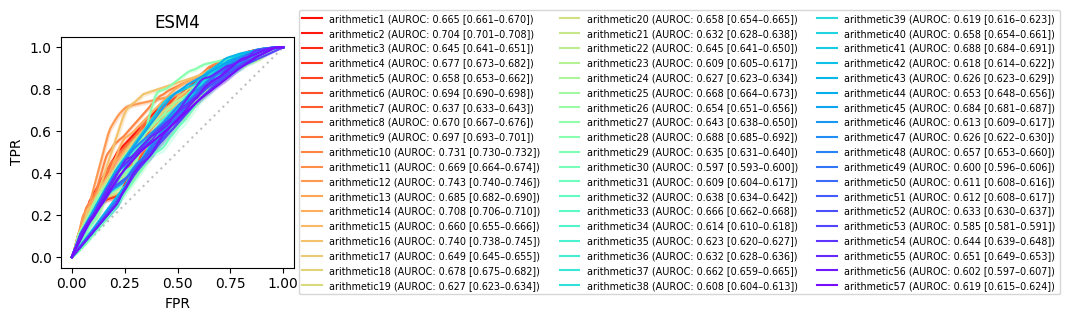

In [417]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.subplots_adjust(wspace=.55)

df_roc_integrated = roc_multimetric_integration(df_roc)
fixed_cmap = {
    **fixed_cmap, 
    **{
        f"arithmetic{i + 1}": c for i, c in enumerate(
            sns.color_palette("rainbow_r", len(arr_condition))
        )
    }
}

# sorted_feat_names = pd.DataFrame(aurocs).mean().sort_values(ascending=False).index
# sorted_cmap = pd.Series(
#     [i for i in range(len(metrics))], index=metrics
# )[sorted_feat_names].apply(lambda i: cmap[i]).tolist()
df_auroc = pd.DataFrame({
    "AUROC": np.array([aurocs[k] for k in metrics]).ravel(),
    "feat_names": np.array([[k] * len(aurocs[k]) for k in metrics]).ravel(),
    "": np.array([[k.split("arithmetic")[-1]] * len(aurocs[k]) for k in metrics]).ravel()
})


df_mean_auroc = df_auroc.loc[
    :, ["feat_names", "AUROC"]
].groupby("feat_names").mean().loc[metrics]


for i, key in enumerate(metrics):
    df_roc_sep = df_roc_integrated.loc[
        df_roc_integrated.feat_names == key, :
    ]
    low, high = aurocs_ci[key].low, aurocs_ci[key].high
    ax.plot(
        df_roc_sep.x,
        df_roc_sep.iloc[:, 2:].mean(axis=1),
        c=fixed_cmap[metrics[i]],
        label=metrics[i] + f" (AUROC: {f2s(df_mean_auroc.loc[key].item())} [{f2s(low)}–{f2s(high)}])", 
    )
    ax.fill_between(
        df_roc_sep.x, 
        df_roc_sep.iloc[:, 2:].mean(axis=1) - df_roc_sep.iloc[:, 2:].std(axis=1),
        df_roc_sep.iloc[:, 2:].mean(axis=1) + df_roc_sep.iloc[:, 2:].std(axis=1),
        color=fixed_cmap[metrics[i]], alpha=.2, zorder=-(i + 1) * 10
    )

ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
ax.set(title="ESM4", xlabel="FPR", ylabel="TPR")
ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5), ncol=3)

# fig.savefig(f"{outputdir}/test4_roc_arithmetic", **kwarg_savefig)

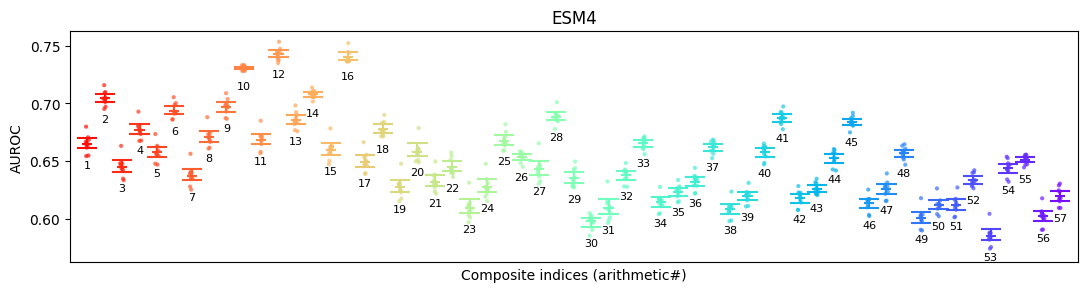

In [418]:
fig, ax = plt.subplots(figsize=(13, 3))

sns.stripplot(
    data=df_auroc, 
    y="AUROC", x="", size=3, hue="", 
    ax=ax, 
    palette=[fixed_cmap[v] for v in metrics], alpha=.7
)

ax.set_xlim([-1, 57])
ax.set_ylim(np.array(ax.get_ylim()) + np.array([-.003, 0]))
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(df_auroc.loc[:, ""].unique(), rotation=90, ha="right")

xlim = (lambda v1, v2: v2 - v1)(*np.sort(np.array(ax.get_xlim())))
        
for i, name in enumerate(metrics):
    ax.hlines(df_mean_auroc.loc[name], i - (xlim * .005), i + (xlim * .005), color=fixed_cmap[name])
    ax.hlines(aurocs_ci[name].low, i - (xlim * .01), i + (xlim * .01), color=fixed_cmap[name])
    ax.hlines(aurocs_ci[name].high, i - (xlim * .01), i + (xlim * .01), color=fixed_cmap[name])
    ax.vlines(i, aurocs_ci[name].low, aurocs_ci[name].high, color=fixed_cmap[name])
    ax.text(i, aurocs_ci[name].low - 0.01, f"{i + 1}", ha="center", va="top", size=8)

ax.tick_params(labelbottom=False, bottom=False)
# ax.spines["bottom"].set_visible(False)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)

ax.set(title="ESM4", xlabel="Composite indices (arithmetic#)")


fig.savefig(f"{outputdir}/test4_roc_arithmetic", **kwarg_savefig)

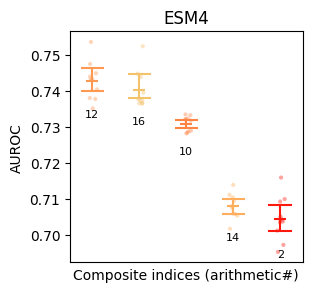

In [419]:
fig, ax = plt.subplots(figsize=(3, 3))

metrics = df_mean_auroc.sort_values("AUROC", ascending=False).index[:5].tolist()

df_temp = df_auroc.loc[
    np.sum([df_auroc.feat_names == m for m in metrics], axis=0).astype(bool), :
]

sns.stripplot(
    data=df_temp.loc[
        df_temp["feat_names"].apply(
            lambda name: {v: i for i, v in enumerate(metrics)}[name]
        ).sort_values().index, :
    ], 
    y="AUROC", x="", size=3, hue="", 
    ax=ax, 
    palette=[fixed_cmap[v] for v in metrics], alpha=.4
)

# ax.set_xlim([-1, 57])
# ax.set_ylim(np.array(ax.get_ylim()) + np.array([-.003, 0]))
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(df_auroc.loc[:, ""].unique(), rotation=90, ha="right")

xlim = (lambda v1, v2: v2 - v1)(*np.sort(np.array(ax.get_xlim())))
        
for i, name in enumerate(metrics):
    ax.hlines(df_mean_auroc.loc[name], i - (xlim * .025), i + (xlim * .025), color=fixed_cmap[name])
    ax.hlines(aurocs_ci[name].low, i - (xlim * .05), i + (xlim * .05), color=fixed_cmap[name])
    ax.hlines(aurocs_ci[name].high, i - (xlim * .05), i + (xlim * .05), color=fixed_cmap[name])
    ax.vlines(i, aurocs_ci[name].low, aurocs_ci[name].high, color=fixed_cmap[name])
    ax.text(i, aurocs_ci[name].low - 0.005, f"{metrics[i].split('arithmetic')[-1]}", ha="center", va="top", size=8)

ax.tick_params(labelbottom=False, bottom=False)
# ax.spines["bottom"].set_visible(False)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)

ax.set(title="ESM4", xlabel="Composite indices (arithmetic#)")


fig.savefig(f"{outputdir}/test4_auc_arithmetic", **kwarg_savefig)

[Text(0.5, 54.49415204678361, 'Composite indices (arithmetic#)')]

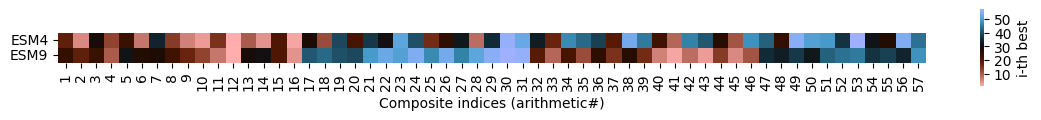

In [439]:
fig, ax = plt.subplots(figsize=(14, 2))

sns.heatmap(
    data=pd.DataFrame(
        {
            "ESM4": np.arange(1, 58, 1)[
                np.argsort(
                    np.arange(57)[
                        np.argsort(df_mean_auroc.AUROC.values)
                    ][::-1]
                )
            ],
            "ESM9": np.array([
                24, 18, 23, 10, 31, 27, 28, 22, 17, 13,  7,  1, 29, 30, 20,  4, 41,
                43, 40, 39, 49, 52, 50, 54, 47, 53, 46, 51, 55, 57, 56, 19,  9, 21,
                12, 25, 15, 26, 16,  6,  2,  8,  3, 14,  5, 11, 35, 33, 37, 32, 42,
                44, 45, 36, 38, 34, 48
            ])
        },
        index=[v.split("arithmetic")[-1] for v in df_mean_auroc.index]
    ).T,
    cbar_kws={"label": "i-th best", "shrink": .5, 'ticks': [10, 20, 30, 40, 50]},
    cmap="berlin_r", square=True, ax=ax
    
)

ax.set(xlabel="Composite indices (arithmetic#)")

[Text(0.5, 1.0, 'ESM4'), Text(0.5, 0, 'FPR'), Text(0, 0.5, 'TPR')]

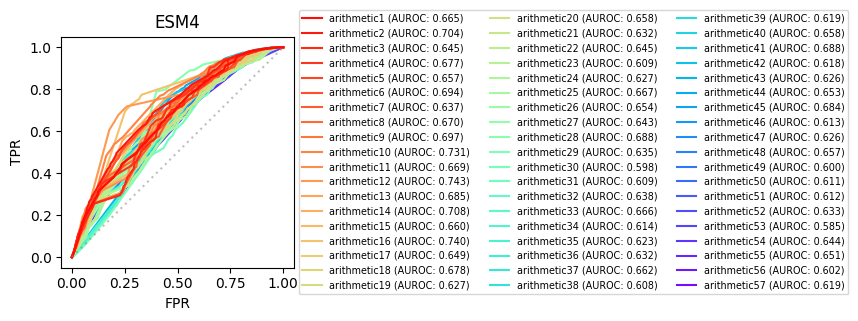

In [278]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [
    eval("df.arithmetic" + f"{i + 1}") for i in range(len(arr_condition))
]

names = [
    f"arithmetic{i + 1}" for i in range(len(features))
]

fixed_cmap = {
    **fixed_cmap, 
    **{
        f"arithmetic{i + 1}": c for i, c in enumerate(
            sns.color_palette("rainbow_r", len(features))
        )
    }
}

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {f2s(roc_auc_score(df.better_with_pb, y))})", 
        c=fixed_cmap[names[i]],
        zorder=-i
    )

ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5), ncol=3)
ax.set(title="ESM4", xlabel="FPR", ylabel="TPR")

# fig.savefig(f"{outputdir}/test4_roc_arithmetic", **kwarg_savefig)

[Text(0.5, 1.0, 'ESM4')]

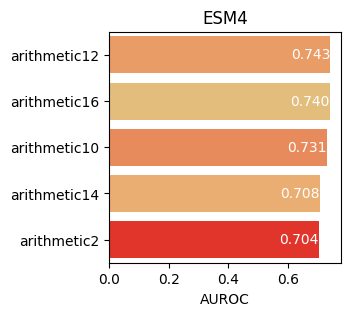

In [279]:
fig, ax = plt.subplots(figsize=(3, 3))

df_bar_arith = pd.DataFrame({
    "": names,
    "AUROC": [roc_auc_score(df.better_with_pb, y) for y in features],
    "cmap": [fixed_cmap[v] for v in names],
}, index=names).sort_values("AUROC", ascending=False).iloc[:5, :]

sns.barplot(
    data=df_bar_arith,
    x="AUROC", y="",
    hue="", legend=False,
    palette=df_bar_arith.cmap.tolist()
)

for i, auroc in enumerate(df_bar_arith.AUROC):
    ax.text(
        auroc, i, f2s(auroc), 
        ha="right", va="center", color="w"
    )

ax.set(title="ESM4")

# fig.savefig(f"{outputdir}/test4_auc_arithmetic", **kwarg_savefig)

In [280]:
pbsi_features = [
    'positive_pathway_coverage',
    'max_positive_edge_density',
    'mean_positive_edge_density',
]

[Text(0.5, 1.0, 'ESM4'), Text(0.5, 0, 'FPR'), Text(0, 0.5, 'TPR')]

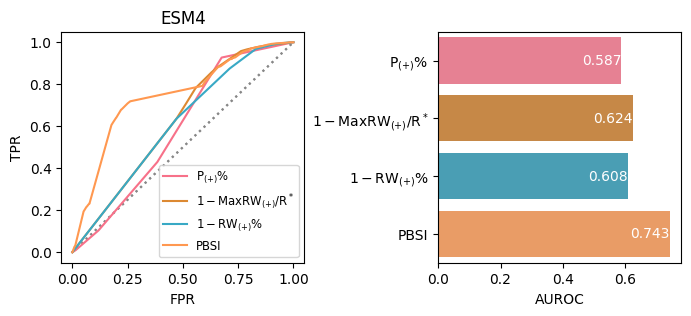

In [281]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=.55)

df_concat = pd.concat(
    [
        # df_bar.loc[[v for v in df_bar.loc[top10, :].index if v in key_features], :],
        df_bar.loc[[v for v in df_bar.loc[pbsi_features, :].index], :],
        df_bar_arith.iloc[:1, :]
    ],
    axis=0
)

features = [
    df.loc[:, v] for v in df_concat.index
]

names = [
    r"$1-$" + feat_names_short[v] if v in negs else v for v in df_concat.index
]

names = [
    feat_names_short[v] if v in key_features else v for v in names
]

names = [
    "PBSI" if "arithmetic" in v else v for v in names
]


cmap = df_concat.cmap

df_bar_concat = pd.DataFrame({
    "": names,
    "AUROC": [roc_auc_score(df.better_with_pb, y) for y in features],
    "cmap": df_concat.cmap
}, index=df_concat.index)
# .sort_values("AUROC", ascending=False)

sns.barplot(
    data=df_bar_concat, x="AUROC", y="",
    hue="", legend=False, ax=ax[1],
    palette=df_bar_concat.cmap.values.tolist()
)

for i, y in enumerate(features):
    ax[0].plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i], 
        # + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax[0].plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
    
    ax[1].text(
        df_bar_concat.AUROC[i], 
        np.where(df_bar_concat.loc[:, ""] == names[i])[0].item(), 
        f2s(df_bar_concat.AUROC[i]), ha="right", va="center", color="w"
    )

ax[0].legend(fontsize="small", loc="lower right")
ax[0].set(title="ESM4", xlabel="FPR", ylabel="TPR")

# fig.savefig(f"{outputdir}/test4_roc_integrated", **kwarg_savefig)

In [282]:
xs, ys = np.array([]), np.array([])
feat_names = []
folds = []

metrics = pbsi_features + ["arithmetic12"]
# metrics = top10

aurocs = {key: [] for key in metrics}

for i, (_, te) in enumerate(
    StratifiedKFold(
        n_splits=10, shuffle=True, random_state=0
    ).split(df[metrics], df.better_with_pb)
):
    x_te, y_te = df[metrics].loc[te, :], df.better_with_pb[te]

    for key in metrics:
        x, y = roc_curve(y_te, x_te[key])[:2]
        xs, ys = np.hstack([xs, x]), np.hstack([ys, y])
        feat_names += [key] * x.size
        folds += [i] * x.size
        aurocs[key] += [roc_auc_score(y_te, x_te[key])]


df_roc = pd.DataFrame({
    "x": xs, "y": ys, "feat_names": feat_names, "folds": folds
})

aurocs_ci = {
    k: bootstrap(
        (v,), **kwarg_bootstrap
    ).confidence_interval for k, v in aurocs.items()
}

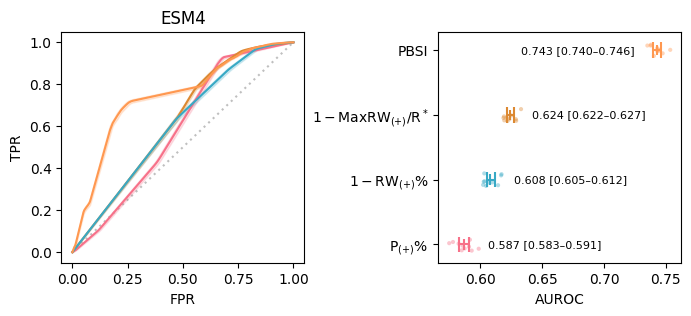

In [283]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=.55)

df_roc_integrated = roc_multimetric_integration(df_roc)
cmap = [fixed_cmap[v] for v in metrics]

for i, key in enumerate(metrics):
    df_roc_sep = df_roc_integrated.loc[
        df_roc_integrated.feat_names == key, :
    ]
    ax[0].plot(
        df_roc_sep.x,
        df_roc_sep.iloc[:, 2:].mean(axis=1),
        c=cmap[i]
    )
    ax[0].fill_between(
        df_roc_sep.x, 
        df_roc_sep.iloc[:, 2:].mean(axis=1) - df_roc_sep.iloc[:, 2:].std(axis=1),
        df_roc_sep.iloc[:, 2:].mean(axis=1) + df_roc_sep.iloc[:, 2:].std(axis=1),
        color=cmap[i], alpha=.2, zorder=-(i + 1) * 10
    )

ax[0].plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
ax[0].set(title="ESM4", xlabel="FPR", ylabel="TPR")
# ax.legend(fontsize="x-small", loc="lower right")

sorted_feat_names = pd.DataFrame(aurocs).mean().sort_values(ascending=False).index
sorted_cmap = pd.Series(
    [i for i in range(len(metrics))], index=metrics
)[sorted_feat_names].apply(lambda i: cmap[i]).tolist()

fmt_name = lambda name: "PBSI" if "arithmetic" in name else [
    feat_names_short[name], "$1-$" + feat_names_short[name]
][name in negs]

sorted_auroc = pd.DataFrame({
    "AUROC": np.array([aurocs[k] for k in sorted_feat_names]).ravel(),
    "feat_names": np.array([[k] * len(aurocs[k]) for k in sorted_feat_names]).ravel(),
    "": np.array([
        [fmt_name(k)] * len(aurocs[k]) for k in sorted_feat_names
    ]).ravel()
})

# fixed_cmap = {k: v for k, v in zip(sorted_feat_names, sorted_cmap)}

sns.stripplot(
    data=sorted_auroc, 
    x="AUROC", y="", size=3, hue="", 
    ax=ax[1], 
    palette=sorted_cmap, alpha=.4
)
# ax[1].set(xlim=(0, ax[1].get_xlim()[1]))


sorted_mean_auroc = sorted_auroc.loc[
    :, ["feat_names", "AUROC"]
].groupby("feat_names").mean().loc[sorted_feat_names]
        
ylim = (lambda v1, v2: v2 - v1)(*np.sort(np.array(ax[1].get_ylim())))
        
for i, name in enumerate(sorted_feat_names):
    ax[1].vlines(sorted_mean_auroc.loc[name], i - (ylim * .02), i + (ylim * .02), color=sorted_cmap[i])
    ax[1].vlines(aurocs_ci[name].low, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax[1].vlines(aurocs_ci[name].high, i - (ylim * .03), i + (ylim * .03), color=sorted_cmap[i])
    ax[1].hlines(i, aurocs_ci[name].low, aurocs_ci[name].high, color=sorted_cmap[i])
    center = np.array(ax[1].get_xlim()).mean()
    is_larger = (sorted_mean_auroc.loc[name] > center).item()
    low, high = aurocs_ci[name].low, aurocs_ci[name].high
    ax[1].text(
        low - 0.015 if is_larger else high + 0.015,
        i, f"{f2s(sorted_mean_auroc.loc[name].item())} [{f2s(low)}–{f2s(high)}]",
        ha="right" if is_larger else "left", va="center", size=8
    )
# fig.savefig(f"{outputdir}/test4_roc_integrated", **kwarg_savefig)

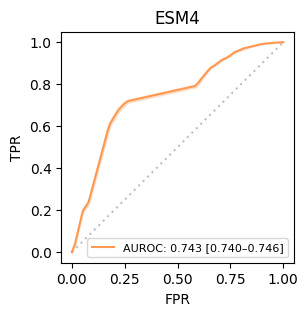

In [290]:
fig, ax = plt.subplots(figsize=(3, 3))

df_roc_integrated = roc_multimetric_integration(df_roc)
cmap = [fixed_cmap[v] for v in ["arithmetic12"]]

for i, key in enumerate(["arithmetic12"]):
    df_roc_sep = df_roc_integrated.loc[
        df_roc_integrated.feat_names == key, :
    ]
    low, high = aurocs_ci[key].low, aurocs_ci[key].high
    ax.plot(
        df_roc_sep.x,
        df_roc_sep.iloc[:, 2:].mean(axis=1),
        c=cmap[i],
        label=f"AUROC: {f2s(sorted_mean_auroc.loc[key].item())} [{f2s(low)}–{f2s(high)}]"
    )
    ax.fill_between(
        df_roc_sep.x, 
        df_roc_sep.iloc[:, 2:].mean(axis=1) - df_roc_sep.iloc[:, 2:].std(axis=1),
        df_roc_sep.iloc[:, 2:].mean(axis=1) + df_roc_sep.iloc[:, 2:].std(axis=1),
        color=cmap[i], alpha=.2, zorder=-(i + 1) * 10
    )

ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
ax.set(title="ESM4", xlabel="FPR", ylabel="TPR")
ax.legend(fontsize=8)

fig.savefig(f"{outputdir}/test4_roc_integrated", **kwarg_savefig)

[Text(0.5, 1.0, 'PBSI (ESM4)'), Text(0.5, 0, 'FPR'), Text(0, 0.5, 'TPR')]

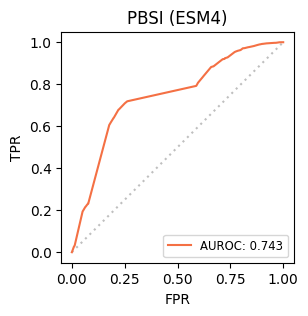

In [37]:
fig, ax = plt.subplots(figsize=(3, 3))

df_concat = df_bar_arith.iloc[:1, :]

features = [
    df.loc[:, v] for v in df_concat.index
]

names = ["PBSI"]


cmap = df_concat.cmap

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        # label=names[i] + 
        label=f"AUROC: {roc_auc_score(df.better_with_pb, y).round(3)}", 
        c=cmap[i]
    )
    ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="small", loc="lower right")
ax.set(title="PBSI (ESM4)", xlabel="FPR", ylabel="TPR")

# fig.savefig(f"{outputdir}/test4_roc_integrated", **kwarg_savefig)

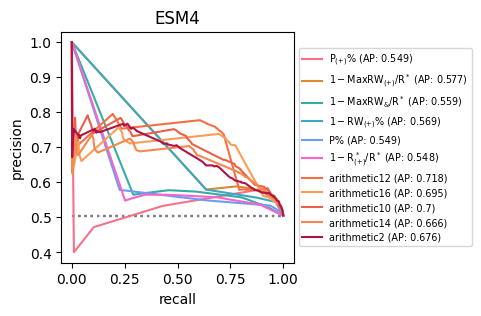

In [34]:
fig, ax = plt.subplots(figsize=(3, 3))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    base = df.better_with_pb.value_counts().cumsum()[0] / df.better_with_pb.value_counts().cumsum()[1]
    ax.plot([0, 1], [base, base], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5))
ax.set(title="ESM4", xlabel="recall", ylabel="precision")

fig.savefig(f"{outputdir}/test4_pr", **kwarg_savefig)

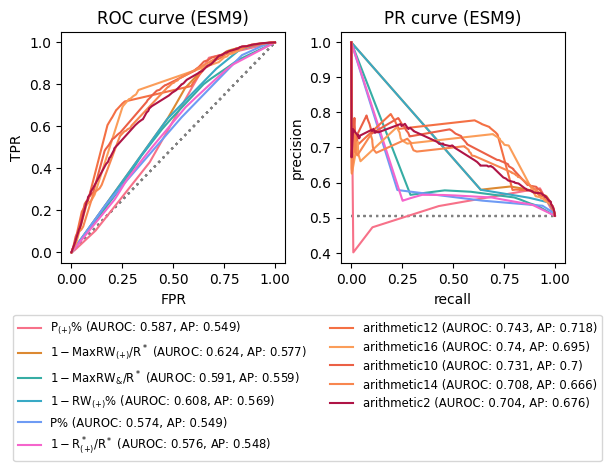

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 3))
plt.subplots_adjust(wspace=.25)

df_concat = pd.concat(
    [
        df_bar.loc[[v for v in df_bar.loc[key_features, :].index if v in key_features], :],
        df_bar_arith
    ],
    axis=0
)

features = [
    df.loc[:, v] for v in df_concat.index
]

names = [
    r"$1-$" + feat_names_short[v] if v in negs else v for v in df_concat.index
]

names = [
    feat_names_short[v] if v in key_features else v for v in names
]


cmap = df_concat.cmap

for i, y in enumerate(features):
    ax[0].plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax[0].plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
    ax[1].plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + \
        f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)}, " + \
        f"AP: {average_precision_score(df.better_with_pb, y).round(3)})" , 
        c=cmap[i]
    )
    base = df.better_with_pb.value_counts().cumsum()[0] / df.better_with_pb.value_counts().cumsum()[1]
    ax[1].plot([0, 1], [base, base], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax[1].legend(fontsize="small", loc="upper center", bbox_to_anchor=(-.15, -.2), ncol=2)
ax[0].set(
    title="ROC curve (ESM9)", xlabel="FPR", ylabel="TPR"
)
ax[1].set(title="PR curve (ESM9)", xlabel="recall", ylabel="precision")

fig.savefig(f"{outputdir}/test4_roc_pr_integrated", **kwarg_savefig)

In [371]:
from sklearn.linear_model import LogisticRegression

In [379]:
xs, ys = np.array([]), np.array([])
feat_names = []
folds = []

metrics = pbsi_features
# metrics = top10

aurocs = {key: [] for key in ["Logistic regression", "PBSI"]}

for i, (tr, te) in enumerate(
    StratifiedKFold(
        n_splits=10, shuffle=True, random_state=0
    ).split(df[metrics], df.better_with_pb)
):
    x_tr, y_tr = df[metrics].loc[tr, :], df.better_with_pb[tr]
    x_te, y_te = df[metrics].loc[te, :], df.better_with_pb[te]

    for key in ["Logistic regression", "PBSI"]:
        if key == "Logistic regression":
            lr = LogisticRegression(random_state=0)
            lr.fit(x_tr, y_tr)
            x, y = roc_curve(y_te, lr.predict_proba(x_te)[:, 1])[:2]
            aurocs[key] += [roc_auc_score(y_te, lr.predict_proba(x_te)[:, 1])]
        else:
            x, y = roc_curve(y_te, df.loc[x_te.index, "arithmetic12"])[:2]
            aurocs[key] += [roc_auc_score(y_te, df.loc[x_te.index, "arithmetic12"])]

        xs, ys = np.hstack([xs, x]), np.hstack([ys, y])
        feat_names += [key] * x.size
        folds += [i] * x.size


df_roc = pd.DataFrame({
    "x": xs, "y": ys, "feat_names": feat_names, "folds": folds
})

aurocs_ci = {
    k: bootstrap(
        (v,), **kwarg_bootstrap
    ).confidence_interval for k, v in aurocs.items()
}

/tmp/ipykernel_6706/702000591.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ci_labels, fontsize="small")


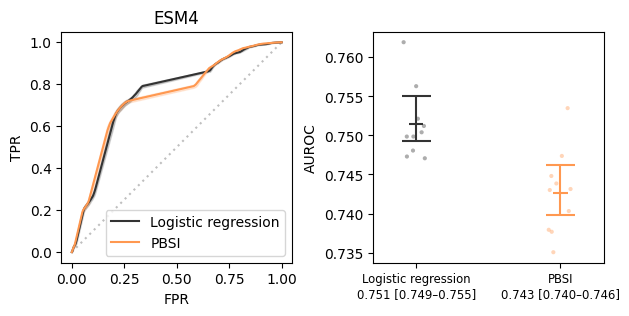

In [407]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(wspace=.35)

df_roc_integrated = roc_multimetric_integration(df_roc)
cmap = [".2", fixed_cmap["arithmetic12"]]

for i, key in enumerate(["Logistic regression", "PBSI"]):
    df_roc_sep = df_roc_integrated.loc[
        df_roc_integrated.feat_names == key, :
    ]
    ax[0].plot(
        df_roc_sep.x,
        df_roc_sep.iloc[:, 2:].mean(axis=1),
        c=cmap[i], label=key
    )
    ax[0].fill_between(
        df_roc_sep.x, 
        df_roc_sep.iloc[:, 2:].mean(axis=1) - df_roc_sep.iloc[:, 2:].std(axis=1),
        df_roc_sep.iloc[:, 2:].mean(axis=1) + df_roc_sep.iloc[:, 2:].std(axis=1),
        color=cmap[i], alpha=.2, zorder=-(i + 1) * 10
    )

ax[0].plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
ax[0].set(title="ESM4", xlabel="FPR", ylabel="TPR")
ax[0].legend(loc="lower right")

sorted_feat_names = pd.DataFrame(aurocs).mean().sort_values(ascending=False).index
sorted_cmap = pd.Series(
    [i for i in range(len(["Logistic regression", "PBSI"]))], index=["Logistic regression", "PBSI"]
)[sorted_feat_names].apply(lambda i: cmap[i]).tolist()

# fmt_name = lambda name: "PBSI" if "arithmetic" in name else [
#     feat_names_short[name], "$1-$" + feat_names_short[name]
# ][name in negs]

sorted_auroc = pd.DataFrame({
    "AUROC": np.array([aurocs[k] for k in sorted_feat_names]).ravel(),
    "feat_names": np.array([[k] * len(aurocs[k]) for k in sorted_feat_names]).ravel(),
    "": np.array([
        [k] * len(aurocs[k]) for k in sorted_feat_names
    ]).ravel()
})

# fixed_cmap = {k: v for k, v in zip(sorted_feat_names, sorted_cmap)}

sns.stripplot(
    data=sorted_auroc, 
    y="AUROC", x="", size=3, hue="", 
    ax=ax[1], 
    palette=sorted_cmap, alpha=.4
)
# ax[1].set(xlim=(0, ax[1].get_xlim()[1]))


sorted_mean_auroc = sorted_auroc.loc[
    :, ["feat_names", "AUROC"]
].groupby("feat_names").mean().loc[sorted_feat_names]
        
xlim = (lambda v1, v2: v2 - v1)(*np.sort(np.array(ax[1].get_xlim())))
ci_labels = []
        
for i, name in enumerate(sorted_feat_names):
    ax[1].hlines(sorted_mean_auroc.loc[name], i - (xlim * .025), i + (xlim * .025), color=sorted_cmap[i])
    ax[1].hlines(aurocs_ci[name].low, i - (xlim * .05), i + (xlim * .05), color=sorted_cmap[i])
    ax[1].hlines(aurocs_ci[name].high, i - (xlim * .05), i + (xlim * .05), color=sorted_cmap[i])
    ax[1].vlines(i, aurocs_ci[name].low, aurocs_ci[name].high, color=sorted_cmap[i])
    # center = np.array(ax[1].get_xlim()).mean()
    # is_larger = (sorted_mean_auroc.loc[name] > center).item()
    low, high = aurocs_ci[name].low, aurocs_ci[name].high
    ci_labels += [name + "\n" + f"{f2s(sorted_mean_auroc.loc[name].item())} [{f2s(low)}–{f2s(high)}]"]
    # ax[1].text(
    #     i,
    #     low if is_larger else high,
    #     f"{f2s(sorted_mean_auroc.loc[name].item())} [{f2s(low)}–{f2s(high)}]",
    #     ha="right" if is_larger else "left", va="center", size=8
    # )
ax[1].set_xticklabels(ci_labels, fontsize="small")
ax[1].set_xlim([-.3, 1.3])

fig.savefig(f"{outputdir}/test4_logistic_regression", **kwarg_savefig)

In [441]:
lr.coef_

array([[3.68662566, 2.09381904, 4.54325107]])